In [1]:
import os
import time
import glob
import yaml
import argparse
import logging
import pathlib
import struct
import warnings
from random import randint

import numpy as np
import torch
from tqdm import tqdm
from scipy.spatial import ConvexHull, Delaunay, cKDTree, KDTree
from sklearn.neighbors import NearestNeighbors

import open3d as o3d
import trimesh
import k3d
import wandb

warnings.simplefilter(action='ignore', category=FutureWarning)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Output()

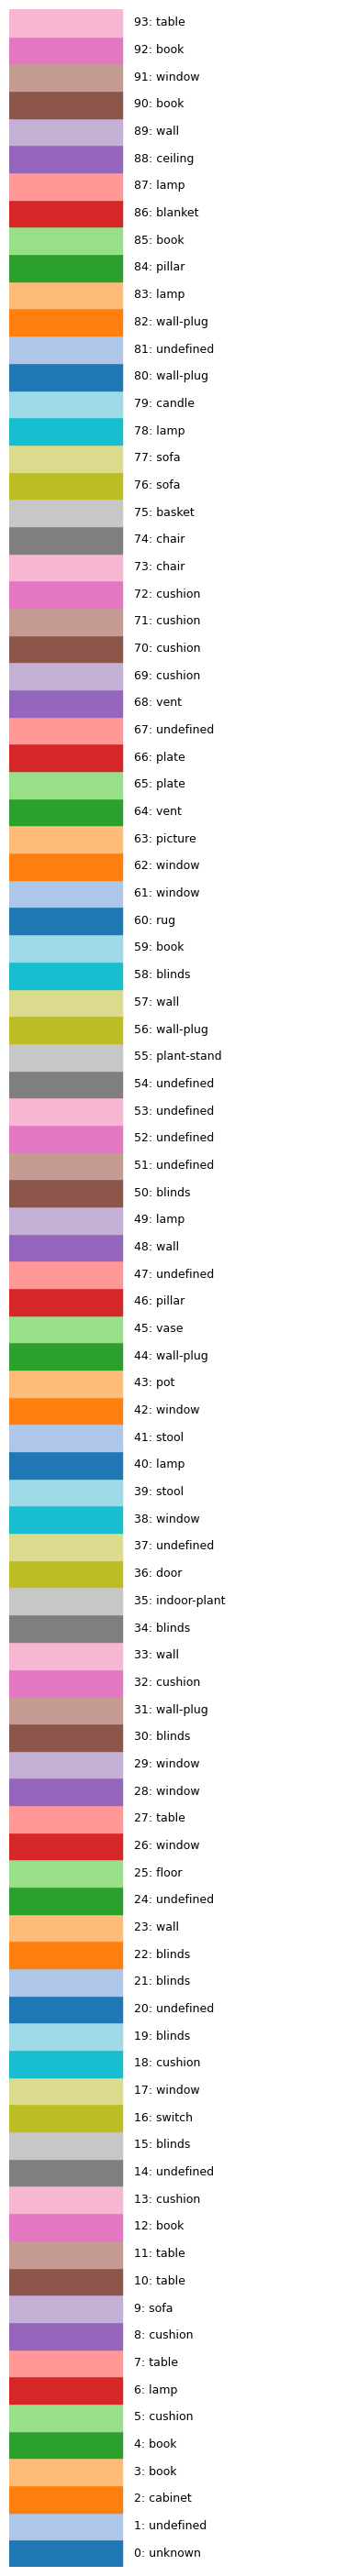

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import k3d
from plyfile import PlyData
from pathlib import Path
import json
import matplotlib.patches as mpatches

def rgb_to_uint(rgb):
    r, g, b = rgb
    return (int(r) << 16) + (int(g) << 8) + int(b)

# === Load Replica mesh ===
data_root = "/scratch/rhm4nj/cral/datasets/Replica-Dataset/ReplicaSDK"
room_name = "room_0"
room_path = Path(data_root) / room_name

ply_path = room_path / "habitat" / "mesh_semantic.ply"
info_path = room_path / "habitat" / "info_semantic.json"

# === Load class mapping ===
with open(info_path, "r") as f:
    info = json.load(f)

class_mapping = {}
for ele in info["classes"]:
    class_mapping[ele["id"]] = ele["name"]
for ele in info["objects"]:
    class_mapping[ele["id"]] = ele["class_name"]

# === Load mesh data using plyfile ===
plydata = PlyData.read(str(ply_path))
vertex_array = np.stack([
    plydata['vertex']['x'],
    plydata['vertex']['y'],
    plydata['vertex']['z']
], axis=-1)

face_data = plydata['face'].data
face_indices = [f[0] for f in face_data]
object_ids = np.array([f[1] for f in face_data], dtype=np.uint16)

# === Assign each vertex the object_id of the first face it's used in ===
vertex_object_ids = np.zeros(vertex_array.shape[0], dtype=np.uint16)
used = np.zeros(vertex_array.shape[0], dtype=bool)
for face, oid in zip(face_indices, object_ids):
    for v in face:
        if not used[v]:
            vertex_object_ids[v] = oid
            used[v] = True

# === Color vertices based on object_id ===
unique_ids = np.unique(vertex_object_ids)
id_to_color = {
    oid: (np.array(plt.cm.tab20(i % 20)[:3]) * 255).astype(np.uint8)
    for i, oid in enumerate(unique_ids)
}
packed_colors = np.array([
    rgb_to_uint(id_to_color[oid]) for oid in vertex_object_ids
], dtype=np.uint32)

# === Visualize using k3d.points ===
plot = k3d.plot()
plot += k3d.points(
    positions=vertex_array.astype(np.float32),
    colors=packed_colors,
    point_size=0.01,
    name="semantic_points"
)
plot.display()

def show_color_legend(id_to_color, class_mapping, max_classes=100):
    """
    Clean, compact legend: shows color swatches + 'id: class_name' labels.
    """
    shown_ids = sorted(list(id_to_color.keys()))[:max_classes]
    shown_colors = [id_to_color[i] / 255.0 for i in shown_ids]
    shown_labels = [f"{i}: {class_mapping.get(i, 'unknown')}" for i in shown_ids]

    fig, ax = plt.subplots(figsize=(4, 0.3 * len(shown_ids)))
    for i, (color, label) in enumerate(zip(shown_colors, shown_labels)):
        ax.add_patch(mpatches.Rectangle((0, i), 1, 1, color=color))
        ax.text(1.1, i + 0.5, label, va='center', fontsize=9)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, len(shown_ids))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

show_color_legend(id_to_color, class_mapping)


In [47]:
def split_points_by_class(vertex_array, vertex_object_ids, class_index):
    mask = vertex_object_ids == class_index
    points_in_class = vertex_array[mask]
    points_not_in_class = vertex_array[~mask]
    return points_in_class, points_not_in_class

# 72 - chair, 73 - cushion
class_index = 72
points_in, points_out = split_points_by_class(vertex_array, vertex_object_ids, class_index)

print(f"{points_in.shape[0]} points in class {class_index}")
print(f"{points_out.shape[0]} points outside class {class_index}")

plot = k3d.plot()
plot += k3d.points(positions=points_in, color=0x0000FF, point_size=0.01)
plot += k3d.points(positions=points_out, color=0xFF0000, point_size=0.01)
plot.display()

1069 points in class 72
953423 points outside class 72


Output()